In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from scipy import stats 
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import re

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from scipy.interpolate import interp1d

import wget

sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1. Data Understanding

First we have to find data related to Dioxid of Carbone(C02) concentration in the Atmosphere. We can get this information from the Scripps Institution of Oceanography which can shoe monthly, weekly, dayli datasets. For our project, we will use the montly report: monthly_in_situ_co2_mlo.csv.
- source: https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

The information recollected comes the observatory located at about 3,400 m altitude on Mauna Loa Volcano on Hawaii Island. This place has not influence of changing CO2 due it is near local vegetation and the wind prevail well-mixed air to the site. This information is provided from March 1958.

We will use information regarded to C02 concentration which can be model as:

$$ C_ i = F(t_ i) + P_ i + R_ i $$

- F(t_ i) : Trendy pattern
- P_ i : Seasonal pattern
- R_ i : Residual

Later during evaluation we will see if this decomposition is meaningful.

In [14]:
# Download raw data from source:
DataRaw_C02_url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'
DataRaw_C02 = wget.download(DataRaw_C02_url)
print(DataRaw_C02)

monthly_in_situ_co2_mlo (1).csv


In [22]:
# Create the dataframe from csv file:
cols = ["year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"]
df_co2=pd.read_csv("./monthly_in_situ_co2_mlo.csv", skiprows = 57, header=None, names=cols)
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 780 data points of 10 features


,year,month,date1,date2,co2,co2_season_adj,co2_spline_season_adj,co2_spline,co2_fill_7,co2_fill_8
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.70,317.88,315.07,317.51,314.70


## 2. Pre-Processing

After a quick review, the raw dataset has some information which need to be pre-processed before using in the model:
- Usage only the columns year, month, co2(ppm).
- Add columns like time t= (t+0.5)/12.
- Delete comments in " " " and headers which cannot help us to understand the data(skiprows = 57).
- Drop co2 values equal to -99.99 which are some inhomogeneities.
- Drop NaN values.

In [23]:
# Pre-process the dataset:
df_co2 = df_co2.iloc[:,[x for x in range(df_co2.shape[1]) if x in [0,1,4]]]
df_co2["time"] = [(i+0.5)/12 for i in range(0, df_co2.iloc[:,0].size)]
df_co2[df_co2 == -99.99] = np.NaN
df_co2 = df_co2.dropna()
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 768 data points of 4 features


,year,month,co2,time
2,1958,3,315.71,0.208333
3,1958,4,317.45,0.291667
4,1958,5,317.51,0.375000
6,1958,7,315.87,0.541667
7,1958,8,314.93,0.625000


For further modeling, we will split the data into train and test dataset. 

In [24]:
# Take values for x and y
x = df_co2["time"].values
y = df_co2["co2"].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size = 0.20, shuffle=False )

# Define training and testing dataset:
df_co2_train = df_co2[0:len(x_train)]
df_co2_test = df_co2[len(x_train):len(df_co2)]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, df_co2_train.shape, df_co2_test.shape)

(614, 1) (154, 1) (614, 1) (154, 1) (614, 4) (154, 4)


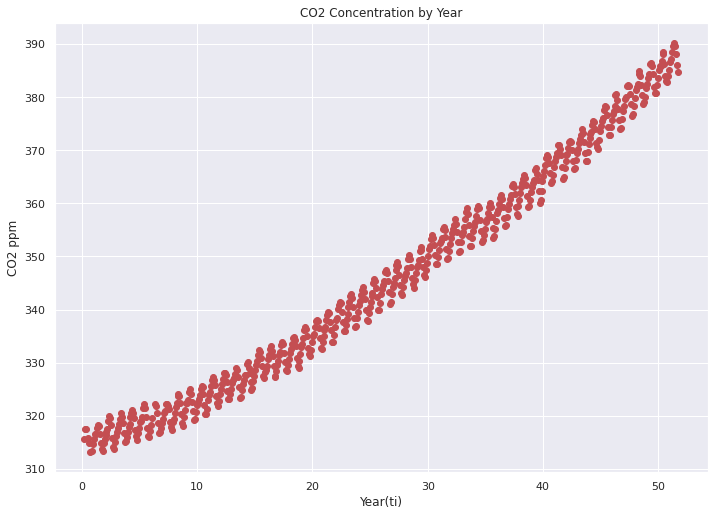

In [29]:
# Plotting The Keeling Curve
plt.scatter(x_train[:,0],y_train[:,0], linewidth = 1, color = 'r')
plt.xlabel('Year(ti)')
plt.ylabel('CO2 ppm')
plt.title('CO2 Concentration by Year')
plt.savefig('./images/CO2-curve.jpg')
plt.show()